CS524: Introduction to Optimization Project Final Report
======================================

## Zachary Collins<br> University of Wisconsin-Madison 

## December 21, 2023
--------------
<br>

# Introduction

<br>

## What is the issue being addressed?

There are many airlines that can be taken and many people have opinions on which has the best service. I aim to find out how variables of a passenger's flight influence their rating  of the flight and whether they would recommend that airline to others in their review. These variables include the different amenities of the flight (as reported by the passenger) and the airline company they flew with. I based this problem off the support vectors problem in question 1 of homework 9, but made large changes in the data being evaluating through regression. I wanted to make sure I am using real life data to compare all the airlines and amenities.


## Where does the data come from and how is it obtained?

I will be using data from Skytrax that github user Juhibojani compiled using data scraping of Skytrax’s reviews. These reviews are moderated by the website to make sure they only contain only relevant information and aren’t harassing the airline with the review.

found here: https://github.com/Juhibhojani/Airline-Reviews-

# The Approach Used

<br>

## What is the optimization problem underlying this project?

The optimization of this problem will be based similar to the support vectors problem in question 1 of homework 9 which is a classification problem. I plan on performing this problem multiple times by using three different datasets that will include different factors that influence the 'overall_rating' and 'recommended'. I will perform the first only using the amenities on the ship as influence for 'overall_rating' and 'recommended'. I will then perform the second using only company name as the influence for 'overall_rating' and 'recommended'. Then I will perform the last using both the company name and ship amenities.

Classification requires training, testing, and tuning sets. I will be using ~90% for training and ~10% for testing. I will be hardcoding the numbers inside the code, but this rule should be considered when performing this. I will shuffle the data as well to prevent bias forming from the way the tables have been sorted previously.

I will also be performing cross validation in order to check the error rates and compare them between different runs.

A large part of this optimization problem is using the support vectors approach. These support vectors are incredibly important for helping me determine how strong the correlation is between the feature and classifying it correctly. I will be pulling these values out at the end of the optimization in order to show visually which features are most influential for reviewers.


## What are the deliverables?

- Import the data into GAMS
- Format the data for ease of use in GAMS
- Perform the first optimization, record the results/error
- Perform the second optimization, record the results/error
- Perform the final optimization, record the results/error
- Display the amenities with the most correlation visually
- Display the airlines with the most correlation visually
- Display the airlines/names with the most correlation visually
- Final comparison / conclusion on results

# The Optimization Model

<br>

## Setup For All Three Data Sets

Here I am loading in all my necessary libraries.

I have dropped 3 columns from the original dataset: "Airline_review.csv" to create "airline_v3.csv". These columns were the actual review itself, the route, and review title.

I am also cleaning the data by dropping all empty values and converting all the data into numeric types that GAMS accepts. I changed the names in order to create consistency.

I then shuffle and reset indices.

Finally, I format the three datasets to have their specified columns.

- only amenities (no_airlines)
- only airline names (only_airlines)
- Combined (split_airlines)

In [1]:
#setup
%load_ext gams.magic
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#import CSV and remove rows with empty data
df = pd.read_csv('airline_v3.csv')
df = df.dropna()

#convert booleans and dates to numeric data for GAMS
df["Recommended"] = df["Recommended"].map(dict(yes=1,no=0))
df["Date Flown"] = pd.to_numeric(df["Date Flown"].str[-4:])
df["Review Date"] = pd.to_numeric(df["Review Date"].str[-4:])
df["Verified"] = df["Verified"].astype(int)

#split up 'seat type' and 'type of traveller' from strings into boolean ints based on the category for GAMS
df = pd.concat([df, df['Seat Type'].str.get_dummies().astype(bool).astype(int)], axis=1)
df = df.drop('Seat Type', axis=1)
df = pd.concat([df, df['Type Of Traveller'].str.get_dummies().astype(bool).astype(int)], axis=1)
df = df.drop('Type Of Traveller', axis=1)

#reset the index to match new changes and fix the names
df = df.reset_index(drop=True)
df.columns = ['airline_name', 'review_year', 'flown_year', 'recommended', 'verified', 'overall_rating', 'seat_comfort', 'cabin_staff_service', 'food_and_beverage', 'ground_service', 'inflight_entertainment', 'wifi_and_connectivity', 'value_for_money', 'business_class_seat', 'economy_class_seat', 'first_class_seat', 'premium_economy_seat', 'business_passenger', 'couple_leisure_passenger', 'family_leisure_passenger', 'solo_leisure_passenger']

#replace whitespace with underscores for airline names
df['airline_name'] = df['airline_name'].replace(' ', '_', regex=True)

# shuffle the DataFrame rows
df = df.sample(frac = 1)
df = df.reset_index(drop=True)

#original without the airline names (can be used in gams to determine which factors influence 'overall_rating' without considering brand)
no_airlines = df.drop('airline_name', axis=1)

#original with airlines split into boolean ints (can be used in gams to determine which factors influence 'overall_rating')
split_airlines = pd.concat([df, df['airline_name'].str.get_dummies().astype(bool).astype(int)], axis=1)
split_airlines = split_airlines.drop('airline_name', axis=1)

#only airline booleans ints and 'overall_rating' (based on brand alone)
only_airlines = pd.concat([df['overall_rating'], df['recommended'], df['airline_name']], axis=1, keys=['overall_rating', 'recommended', 'airline_name'])
only_airlines = pd.concat([only_airlines, only_airlines['airline_name'].str.get_dummies().astype(bool).astype(int)], axis=1)
only_airlines = only_airlines.drop('airline_name', axis=1)

### Original Cleaned

In [3]:
display(df)

,airline_name,review_year,flown_year,recommended,verified,overall_rating,seat_comfort,cabin_staff_service,food_and_beverage,ground_service,...,wifi_and_connectivity,value_for_money,business_class_seat,economy_class_seat,first_class_seat,premium_economy_seat,business_passenger,couple_leisure_passenger,family_leisure_passenger,solo_leisure_passenger
0,Aer_Lingus,2023,2023,0,1,1,2.0,1.0,1.0,1.0,...,1.0,1.0,1,0,0,0,1,0,0,0
1,Korean_Air,2019,2019,0,1,1,1.0,1.0,1.0,1.0,...,1.0,1.0,0,1,0,0,0,0,0,1
2,SpiceJet,2022,2022,0,1,1,1.0,1.0,1.0,1.0,...,1.0,1.0,0,1,0,0,0,0,0,1
3,Air_New_Zealand,2022,2022,0,1,5,3.0,5.0,3.0,3.0,...,1.0,3.0,0,1,0,0,0,1,0,0
4,Avelo_Airlines,2022,2022,0,0,1,4.0,4.0,4.0,4.0,...,3.0,1.0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5370,Rwandair,2023,2022,0,0,1,2.0,2.0,2.0,1.0,...,1.0,1.0,0,1,0,0,1,0,0,0
5371,Delta_Air_Lines,2023,2023,1,0,1,5.0,5.0,5.0,5.0,...,5.0,5.0,0,1,0,0,0,0,0,1
5372,Delta_Air_Lines,2023,2023,1,0,1,5.0,5.0,5.0,5.0,...,5.0,5.0,0,1,0,0,1,0,0,0
5373,Virgin_America,2017,2017,0,0,1,3.0,2.0,2.0,1.0,...,3.0,1.0,0,1,0,0,1,0,0,0


### Only Amenities

In [4]:
display(no_airlines)

,review_year,flown_year,recommended,verified,overall_rating,seat_comfort,cabin_staff_service,food_and_beverage,ground_service,inflight_entertainment,wifi_and_connectivity,value_for_money,business_class_seat,economy_class_seat,first_class_seat,premium_economy_seat,business_passenger,couple_leisure_passenger,family_leisure_passenger,solo_leisure_passenger
0,2023,2023,0,1,1,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1,0,0,0,1,0,0,0
1,2019,2019,0,1,1,1.0,1.0,1.0,1.0,2.0,1.0,1.0,0,1,0,0,0,0,0,1
2,2022,2022,0,1,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,1,0,0,0,0,0,1
3,2022,2022,0,1,5,3.0,5.0,3.0,3.0,3.0,1.0,3.0,0,1,0,0,0,1,0,0
4,2022,2022,0,0,1,4.0,4.0,4.0,4.0,4.0,3.0,1.0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5370,2023,2022,0,0,1,2.0,2.0,2.0,1.0,1.0,1.0,1.0,0,1,0,0,1,0,0,0
5371,2023,2023,1,0,1,5.0,5.0,5.0,5.0,5.0,5.0,5.0,0,1,0,0,0,0,0,1
5372,2023,2023,1,0,1,5.0,5.0,5.0,5.0,5.0,5.0,5.0,0,1,0,0,1,0,0,0
5373,2017,2017,0,0,1,3.0,2.0,2.0,1.0,2.0,3.0,1.0,0,1,0,0,1,0,0,0


### Only Airline Names

In [5]:
display(only_airlines)

,overall_rating,recommended,ANA_All_Nippon_Airways,ASKY_Airlines,Adria_Airways,Aegean_Airlines,Aer_Lingus,Aeroflot_Russian_Airlines,Aerolineas_Argentinas,Aeromar,...,XL_Airways_France,Xiamen_Airlines,ZIPAIR,airBaltic,bmi_Regional,easyJet,euroAtlantic_Airways,fastjet,flyadeal,flydubai
0,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5370,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5371,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5372,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5373,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Combined

In [6]:
display(split_airlines)

,review_year,flown_year,recommended,verified,overall_rating,seat_comfort,cabin_staff_service,food_and_beverage,ground_service,inflight_entertainment,...,XL_Airways_France,Xiamen_Airlines,ZIPAIR,airBaltic,bmi_Regional,easyJet,euroAtlantic_Airways,fastjet,flyadeal,flydubai
0,2023,2023,0,1,1,2.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,2019,2019,0,1,1,1.0,1.0,1.0,1.0,2.0,...,0,0,0,0,0,0,0,0,0,0
2,2022,2022,0,1,1,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
3,2022,2022,0,1,5,3.0,5.0,3.0,3.0,3.0,...,0,0,0,0,0,0,0,0,0,0
4,2022,2022,0,0,1,4.0,4.0,4.0,4.0,4.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5370,2023,2022,0,0,1,2.0,2.0,2.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
5371,2023,2023,1,0,1,5.0,5.0,5.0,5.0,5.0,...,0,0,0,0,0,0,0,0,0,0
5372,2023,2023,1,0,1,5.0,5.0,5.0,5.0,5.0,...,0,0,0,0,0,0,0,0,0,0
5373,2017,2017,0,0,1,3.0,2.0,2.0,1.0,2.0,...,0,0,0,0,0,0,0,0,0,0


# Solve for data with only amenities

In [7]:
#set up GAMS exchange for no_airlines
m = gams.exchange_container

i = m.addSet('i',records=no_airlines.index)
cols = m.addSet('cols', records=no_airlines.columns)
data = m.addParameter('data',[i,'*'],records=gams.from2dim(no_airlines))
wsolns = m.addParameter('wsolns',['*',cols])
gsolns = m.addParameter('gsolns',['*'])

trials = m.addSet('trials', records=['t0','t1','t2','t3','t4','t5'])
errvec = m.addParameter('errvec',[trials])
error_rate = m.addParameter('errorrate')

%gams parameter A(i,cols); A(i,cols) = data(i,cols)

--- Warning: The GAMS version (44.4.0) differs from the API version (45.4.0).
--- Warning: The GAMS version (44.4.0) differs from the API version (45.4.0).
--- Warning: The GAMS version (44.4.0) differs from the API version (45.4.0).
--- Warning: The GAMS version (44.4.0) differs from the API version (45.4.0).
--- Warning: The GAMS version (44.4.0) differs from the API version (45.4.0).


In [8]:
%%gams
set j(cols) index of independent variables;
j(cols) = yes$(not sameas(cols, 'recommended') and not sameas(cols, 'overall_rating'));
alias(k,cols)

parameter y(i);
y(i) = -1 + 2$(data(i,'recommended') gt 0 and data(i,'overall_rating') gt 5);

set train(i), tuning(i), test(i);
train(i) = yes$(ord(i) le 4250);
tuning(i) = yes$(ord(i) gt 4250 and ord(i) le 4750);
test(i) = yes$(ord(i) gt 4750);

scalar C /1/;

positive variables delta(i);
variables pobj, w(k), gamma;

display i;

equations defpobj, cons1(i);

cons1(i)$train(i)..
  Y(i)*(sum(k$j(k), A(i,k)*w(k)) - gamma) + delta(i) =g= 1;

defpobj..
  pobj =e= C*sum(i$train(i), delta(i)) + 0.5*sum(k$j(k), sqr(w(k)));

model svmmod /defpobj, cons1/;

solve svmmod using qcp min pobj;

*second solve

variables ay(i), v(k), obj;
equations upp(i), low(i), cons, inter(k), defObj;

inter(k)$j(k)..
v(k) =e= sum(i$train(i), ay(i)*y(i)*A(i,k));

defObj..
obj =e= sum(i$train(i), ay(i)) - 0.5*sum(k$j(k), sqr(v(k)));

cons..
sum(i$train(i), y(i)*ay(i)) =e= 0;

upp(i)$train(i)..
ay(i) =g= 0;

low(i)$train(i)..
ay(i) =l= C;


model dual / upp, low, cons, inter, defObj /;

solve dual using qcp max obj;

wsolns('primal',j) = w.l(j);
gsolns('primal') = gamma.l;
*wsolns('dual',j) = v.l(j);
wsolns('dual', j) = -inter.m(j);
*TODO: office hours for this.
gsolns('dual') = -cons.m;

display wsolns, gsolns;

set folds /f1*f10/;
parameter posVals(trials) / t0 0.1, t1 1, t2 10, t3 100, t4 1000, t5 10000 /;
set err(i);
set diff(i);

loop(trials,
  C = posVals(trials);
  err(i) = no;
  loop(folds,
    tuning(i) = yes$(i.ord gt (folds.ord-1)*700 and i.ord le folds.ord*700);
    train(i) = yes$(not test(i));
    solve svmmod min pobj using qcp;
    loop(tuning,
      if ((sum(j, A(tuning,j)*w.l(j)) - gamma.l) * Y(tuning) < 0,
        err(tuning) = yes;
      );
    );
  );
  errvec(trials) = card(err)/card(train);
);

*best min option
C = 1;

solve svmmod min pobj using qcp;

parameter pred(i);
loop(test,
  if ((sum(j, A(test,j)*w.l(j)) - gamma.l)*y(test) > 0,
    pred(test) = -1;
  else
    pred(test) = 1;
  );
);

errorrate = sum(test$(pred(test) eq 1), pred(test))/card(test);

display wsolns, gsolns, errvec, C, errorrate;

--- Warning: The GAMS version (44.4.0) differs from the API version (45.4.0).
--- Warning: The GAMS version (44.4.0) differs from the API version (45.4.0).


,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),OptimalLocal (2),1.008588e+03,4251,4270,QCP,CONOPT,2.531
1,Normal (1),OptimalLocal (2),1.008588e+03,8520,4269,QCP,CONOPT,3.047
2,Normal (1),OptimalLocal (2),1.146470e+02,4751,4770,QCP,CONOPT,2
3,Normal (1),OptimalLocal (2),1.146470e+02,4751,4770,QCP,CONOPT,0.016
4,Normal (1),OptimalLocal (2),1.146470e+02,4751,4770,QCP,CONOPT,0
...,...,...,...,...,...,...,...,...
58,Normal (1),OptimalLocal (2),1.142275e+07,4751,4770,QCP,CONOPT,0.172
59,Normal (1),OptimalLocal (2),1.142275e+07,4751,4770,QCP,CONOPT,0.172
60,Normal (1),OptimalLocal (2),1.142275e+07,4751,4770,QCP,CONOPT,0.187
61,Normal (1),OptimalLocal (2),1.142275e+07,4751,4770,QCP,CONOPT,0.171


In [9]:
#extract the useful data
errvec_no_airlines = m['errvec'].records
error_rate_no_airlines = m['errorrate'].records
gsolns_no_airlines = m['gsolns'].records
wsolns_no_airlines = m['wsolns'].pivot()

# Solve for data with only airline names

In [10]:
#set up GAMS exchange for only_airlines
m = gams.exchange_container

i = m.addSet('i',records=only_airlines.index)
cols = m.addSet('cols', records=only_airlines.columns)
data = m.addParameter('data',[i,'*'],records=gams.from2dim(only_airlines))
wsolns = m.addParameter('wsolns',['*',cols])
gsolns = m.addParameter('gsolns',['*'])

trials = m.addSet('trials', records=['t0','t1','t2','t3','t4','t5'])
errvec = m.addParameter('errvec',[trials])
error_rate = m.addParameter('errorrate')

%gams parameter A(i,cols); A(i,cols) = data(i,cols)

--- Warning: The GAMS version (44.4.0) differs from the API version (45.4.0).
--- Warning: The GAMS version (44.4.0) differs from the API version (45.4.0).


In [11]:
%%gams
set j(cols) index of independent variables;
j(cols) = yes$(not sameas(cols, 'recommended') and not sameas(cols, 'overall_rating'));
alias(k,cols)

parameter y(i);
y(i) = -1 + 2$(data(i,'recommended') gt 0 and data(i,'overall_rating') gt 5);

set train(i), tuning(i), test(i);
train(i) = yes$(ord(i) le 4250);
tuning(i) = yes$(ord(i) gt 4250 and ord(i) le 4750);
test(i) = yes$(ord(i) gt 4750);

scalar C /1/;

positive variables delta(i);
variables pobj, w(k), gamma;

display i;

equations defpobj, cons1(i);

cons1(i)$train(i)..
  Y(i)*(sum(k$j(k), A(i,k)*w(k)) - gamma) + delta(i) =g= 1;

defpobj..
  pobj =e= C*sum(i$train(i), delta(i)) + 0.5*sum(k$j(k), sqr(w(k)));

model svmmod /defpobj, cons1/;

solve svmmod using qcp min pobj;

*second solve

variables ay(i), v(k), obj;
equations upp(i), low(i), cons, inter(k), defObj;

inter(k)$j(k)..
v(k) =e= sum(i$train(i), ay(i)*y(i)*A(i,k));

defObj..
obj =e= sum(i$train(i), ay(i)) - 0.5*sum(k$j(k), sqr(v(k)));

cons..
sum(i$train(i), y(i)*ay(i)) =e= 0;

upp(i)$train(i)..
ay(i) =g= 0;

low(i)$train(i)..
ay(i) =l= C;


model dual / upp, low, cons, inter, defObj /;

solve dual using qcp max obj;

wsolns('primal',j) = w.l(j);
gsolns('primal') = gamma.l;
*wsolns('dual',j) = v.l(j);
wsolns('dual', j) = -inter.m(j);
*TODO: office hours for this.
gsolns('dual') = -cons.m;

display wsolns, gsolns;

set folds /f1*f10/;
parameter posVals(trials) / t0 0.1, t1 1, t2 10, t3 100, t4 1000, t5 10000 /;
set err(i);
set diff(i);

loop(trials,
  C = posVals(trials);
  err(i) = no;
  loop(folds,
    tuning(i) = yes$(i.ord gt (folds.ord-1)*700 and i.ord le folds.ord*700);
    train(i) = yes$(not test(i));
    solve svmmod min pobj using qcp;
    loop(tuning,
      if ((sum(j, A(tuning,j)*w.l(j)) - gamma.l) * Y(tuning) < 0,
        err(tuning) = yes;
      );
    );
  );
  errvec(trials) = card(err)/card(train);
);

*best min option
C = 1;

solve svmmod min pobj using qcp;

parameter pred(i);
loop(test,
  if ((sum(j, A(test,j)*w.l(j)) - gamma.l)*y(test) > 0,
    pred(test) = -1;
  else
    pred(test) = 1;
  );
);

errorrate = sum(test$(pred(test) eq 1), pred(test))/card(test);

display wsolns, gsolns, errvec, C, errorrate;

--- Warning: The GAMS version (44.4.0) differs from the API version (45.4.0).
--- Warning: The GAMS version (44.4.0) differs from the API version (45.4.0).


,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),OptimalLocal (2),1.023627e+03,4251,4585,QCP,CONOPT,0.25
1,Normal (1),OptimalLocal (2),1.023627e+03,8835,4584,QCP,CONOPT,0.312
2,Normal (1),OptimalLocal (2),1.188811e+02,4751,5085,QCP,CONOPT,0.047
3,Normal (1),OptimalLocal (2),1.188811e+02,4751,5085,QCP,CONOPT,0.016
4,Normal (1),OptimalLocal (2),1.188811e+02,4751,5085,QCP,CONOPT,0.016
...,...,...,...,...,...,...,...,...
58,Normal (1),OptimalLocal (2),1.134003e+07,4751,5085,QCP,CONOPT,0
59,Normal (1),OptimalLocal (2),1.134003e+07,4751,5085,QCP,CONOPT,0
60,Normal (1),OptimalLocal (2),1.134003e+07,4751,5085,QCP,CONOPT,0
61,Normal (1),OptimalLocal (2),1.134003e+07,4751,5085,QCP,CONOPT,0


In [12]:
#extract the useful data
errvec_only_airlines = m['errvec'].records
error_rate_only_airlines = m['errorrate'].records
gsolns_only_airlines = m['gsolns'].records
wsolns_only_airlines = m['wsolns'].pivot()

# Solve for data with amenities and airline names

In [13]:
#set up GAMS exchange for split_airlines
m = gams.exchange_container

i = m.addSet('i',records=split_airlines.index)
cols = m.addSet('cols', records=split_airlines.columns)
data = m.addParameter('data',[i,'*'],records=gams.from2dim(split_airlines))
wsolns = m.addParameter('wsolns',['*',cols])
gsolns = m.addParameter('gsolns',['*'])

trials = m.addSet('trials', records=['t0','t1','t2','t3','t4','t5'])
errvec = m.addParameter('errvec',[trials])
error_rate = m.addParameter('errorrate')

%gams parameter A(i,cols); A(i,cols) = data(i,cols)

--- Warning: The GAMS version (44.4.0) differs from the API version (45.4.0).
--- Warning: The GAMS version (44.4.0) differs from the API version (45.4.0).


In [14]:
%%gams
set j(cols) index of independent variables;
j(cols) = yes$(not sameas(cols, 'recommended') and not sameas(cols, 'overall_rating'));
alias(k,cols)

parameter y(i);
y(i) = -1 + 2$(data(i,'recommended') gt 0 and data(i,'overall_rating') gt 5);

set train(i), tuning(i), test(i);
train(i) = yes$(ord(i) le 4250);
tuning(i) = yes$(ord(i) gt 4250 and ord(i) le 4750);
test(i) = yes$(ord(i) gt 4750);

scalar C /1/;

positive variables delta(i);
variables pobj, w(k), gamma;

display i;

equations defpobj, cons1(i);

cons1(i)$train(i)..
  Y(i)*(sum(k$j(k), A(i,k)*w(k)) - gamma) + delta(i) =g= 1;

defpobj..
  pobj =e= C*sum(i$train(i), delta(i)) + 0.5*sum(k$j(k), sqr(w(k)));

model svmmod /defpobj, cons1/;

solve svmmod using qcp min pobj;

*second solve

variables ay(i), v(k), obj;
equations upp(i), low(i), cons, inter(k), defObj;

inter(k)$j(k)..
v(k) =e= sum(i$train(i), ay(i)*y(i)*A(i,k));

defObj..
obj =e= sum(i$train(i), ay(i)) - 0.5*sum(k$j(k), sqr(v(k)));

cons..
sum(i$train(i), y(i)*ay(i)) =e= 0;

upp(i)$train(i)..
ay(i) =g= 0;

low(i)$train(i)..
ay(i) =l= C;


model dual / upp, low, cons, inter, defObj /;

solve dual using qcp max obj;

wsolns('primal',j) = w.l(j);
gsolns('primal') = gamma.l;
*wsolns('dual',j) = v.l(j);
wsolns('dual', j) = -inter.m(j);
*TODO: office hours for this.
gsolns('dual') = -cons.m;

display wsolns, gsolns;

set folds /f1*f10/;
parameter posVals(trials) / t0 0.1, t1 1, t2 10, t3 100, t4 1000, t5 10000 /;
set err(i);
set diff(i);

loop(trials,
  C = posVals(trials);
  err(i) = no;
  loop(folds,
    tuning(i) = yes$(i.ord gt (folds.ord-1)*700 and i.ord le folds.ord*700);
    train(i) = yes$(not test(i));
    solve svmmod min pobj using qcp;
    loop(tuning,
      if ((sum(j, A(tuning,j)*w.l(j)) - gamma.l) * Y(tuning) < 0,
        err(tuning) = yes;
      );
    );
  );
  errvec(trials) = card(err)/card(train);
);

*best min option
C = 1;

solve svmmod min pobj using qcp;

parameter pred(i);
loop(test,
  if ((sum(j, A(test,j)*w.l(j)) - gamma.l)*y(test) > 0,
    pred(test) = -1;
  else
    pred(test) = 1;
  );
);

errorrate = sum(test$(pred(test) eq 1), pred(test))/card(test);

display wsolns, gsolns, errvec, C, errorrate;

--- Warning: The GAMS version (44.4.0) differs from the API version (45.4.0).
--- Warning: The GAMS version (44.4.0) differs from the API version (45.4.0).


,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),OptimalLocal (2),8.347854e+02,4251,4603,QCP,CONOPT,4
1,Normal (1),OptimalLocal (2),8.347854e+02,8853,4602,QCP,CONOPT,0.547
2,Normal (1),OptimalLocal (2),1.078503e+02,4751,5103,QCP,CONOPT,5.391
3,Normal (1),OptimalLocal (2),1.078503e+02,4751,5103,QCP,CONOPT,0.016
4,Normal (1),OptimalLocal (2),1.078503e+02,4751,5103,QCP,CONOPT,0.016
...,...,...,...,...,...,...,...,...
58,Normal (1),OptimalLocal (2),8.593832e+06,4751,5103,QCP,CONOPT,0.188
59,Normal (1),OptimalLocal (2),8.593832e+06,4751,5103,QCP,CONOPT,0.187
60,Normal (1),OptimalLocal (2),8.593832e+06,4751,5103,QCP,CONOPT,0.203
61,Normal (1),OptimalLocal (2),8.593832e+06,4751,5103,QCP,CONOPT,0.203


In [15]:
#extract the useful data
errvec_split_airlines = m['errvec'].records
error_rate_split_airlines = m['errorrate'].records
gsolns_split_airlines = m['gsolns'].records
wsolns_split_airlines = m['wsolns'].pivot()

# Solution & Analysis

## Choosing a C value

A C value is used in choosing the error rate within the optimization problem. I noticed that the C value was at its lowest on t1 which is equal to 1. This can be noticed as a pattern in the graph across all runs.

## Error Rates

In the graph below, all three runs are shown with the data differentiated by color in the legend. 

With only name as a predictor, the error rate was consistently around ~14%. With amenities only as a predictor, the error rate was a little bit lower sitting around ~12.5%. With the datasets combined, the error rate was significantly lower. The error rate for the combined data sets sits around ~9.5%.

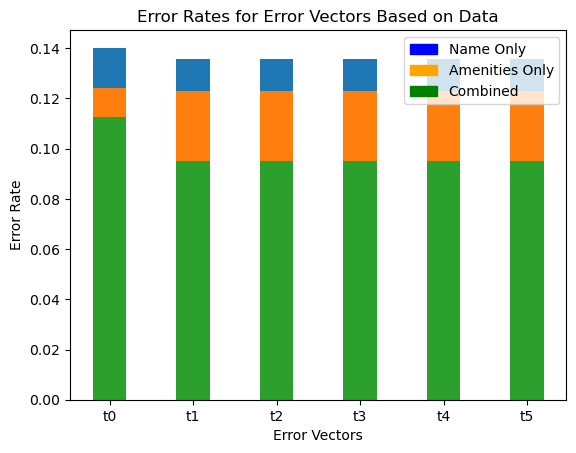

In [16]:
#choosing my C value and error rates
colors = {'Name Only':'blue', 'Amenities Only':'orange', 'Combined':'green'}         
labels = ['Name Only', 'Amenities Only', 'Combined']
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)
plt.xlabel("Error Vectors")
plt.ylabel("Error Rate")
plt.title("Error Rates for Error Vectors Based on Data")

airlineNameErrorBar = plt.bar(errvec_only_airlines['trials'], errvec_only_airlines['value'], width = 0.4)
airlineAmenityErrorBar = plt.bar(errvec_no_airlines['trials'], errvec_no_airlines['value'], width = 0.4)
splitErrorBar = plt.bar(errvec_split_airlines['trials'], errvec_split_airlines['value'], width = 0.4)

## What is this WSolns?

Wsolns are the support vectors I have pulled out of the three optimization problems. I am using these in order to perform sensitivity analysis.

These vectors essentially show me how much the problem determines them to be strong predictors based on how large the value is. They can also be positive (+) or negative (-) which tells whether it is a positive correlation or negative correlation.

## Amenity only analysis

In the graph below, I have marked the most influential amenities that contribute to whether a reviewer will provide an overall rating of greater than 5 out of 10 and whether they would recommend this flight to others.

- The strongest positive correlation is value for money.

- The strongest negative correlation is the flown year.

In [17]:
#function for defining bar colors
def bar_color(df,color1,color2):
    return np.where(df.values>0,color1,color2).T

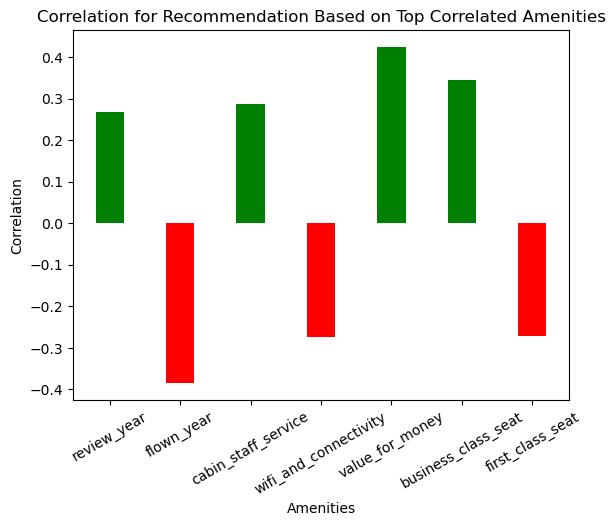

In [23]:
no_airline_data = pd.DataFrame(wsolns_no_airlines)

#twice as much as wanted.
noAirlineFiltered = no_airline_data.drop(no_airline_data.columns[abs(no_airline_data.sum(axis=0)) < 0.5], axis=1)

val_data = noAirlineFiltered.iloc[1]
col_data = noAirlineFiltered.columns

plt.xticks(rotation=30)
plt.xlabel("Amenities")
plt.ylabel("Correlation")
plt.title("Correlation for Recommendation Based on Top Correlated Amenities")

noAirlineBar = plt.bar(col_data,val_data, color=bar_color(val_data,'g','r'), width = 0.4)

## Airline name only analysis

In the graph below, I have marked the most influential airline names that contribute to whether a reviewer will provide an overall rating of greater than 5 out of 10 and whether they would recommend this flight to others.

- All of the correlations are the same which may indicate that their data is likely similar

- This graph doesn't help my understand much of why they are the strongest correlators

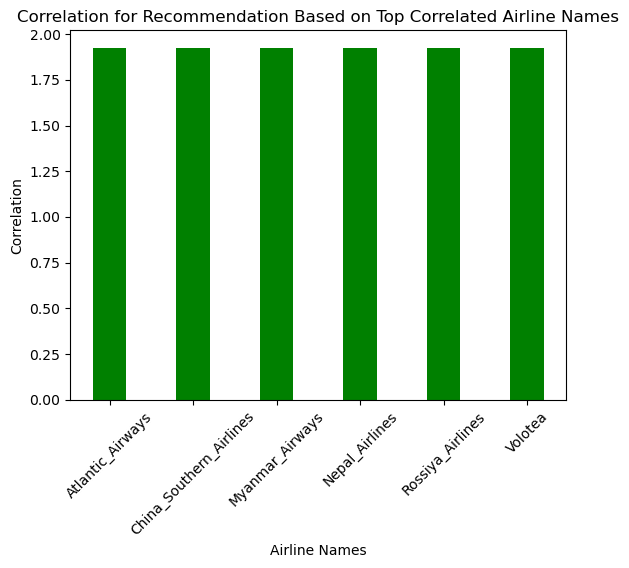

In [19]:
only_airline_data = pd.DataFrame(wsolns_only_airlines)

#twice as much as wanted.
onlyAirlineFiltered = only_airline_data.drop(only_airline_data.columns[abs(only_airline_data.sum(axis=0)) < 2.01], axis=1)

val_data = onlyAirlineFiltered.iloc[1]
col_data = onlyAirlineFiltered.columns

plt.xticks(rotation=45)
plt.xlabel("Airline Names")
plt.ylabel("Correlation")
plt.title("Correlation for Recommendation Based on Top Correlated Airline Names")

noAirlineBar = plt.bar(col_data,val_data, color=bar_color(val_data,'g','r'), width = 0.4)

## Amenity and Name combined analysis

In the graph below, I have marked the most influential names/amenities that contribute to whether a reviewer will provide an overall rating of greater than 5 out of 10 and whether they would recommend this flight to others.

- There are no amenities listed as they are not as strongly linked as these airline's names.

- "Myanmar Airways" and "Nepal Airlines" were both the most strongly correlated in the last analysis

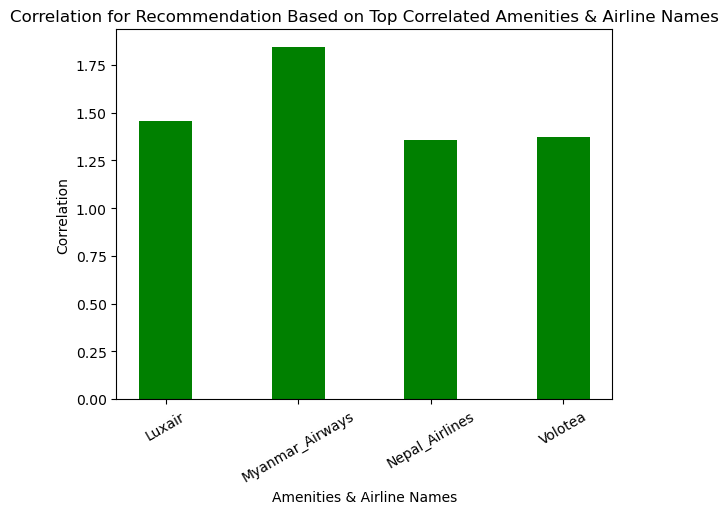

In [24]:
split_data = pd.DataFrame(wsolns_split_airlines)

#twice as much as wanted.
splitFiltered = split_data.drop(split_data.columns[abs(split_data.sum(axis=0)) < 2.7], axis=1)

val_data = splitFiltered.iloc[1]
col_data = splitFiltered.columns

plt.xticks(rotation=30)
plt.xlabel("Amenities & Airline Names")
plt.ylabel("Correlation")
plt.title("Correlation for Recommendation Based on Top Correlated Amenities & Airline Names")

splitBar = plt.bar(col_data,val_data, color=bar_color(val_data,'g','r'), width = 0.4)

# Conclusion & Further Extensions

The combined data set has the lowest error rate which makes sense given that it also has all the data being analyzed. I think the combined data set helps to show that company alone isn't a strong indicator, but with the amenities taken into account, it can be a huge influence on the rating.

Amenities are clear to be important and influential in the decision of reviewers. The strongest positive correlation for amenities is value for money. The strongest negative correlation for amenities is if they flew first class and the year they flew. This makes a lot of sense since many people are going to have completely different ratings for companies depending on how much money they have spent on the flight. If someone spent a lot of money on a flight and they don't have good amenities, it will make sense that they would complain and give a bad review. However, if someone is paying a very little amount for the flight, they are likely not to complain very much since their expectations are already low. This would explain both the first class negative correlation and the value for money positive correlation, but does not explain the flown year's negative correlation. One way I would like to further extend this project is by analyzing the years and why they had an impact. My current guess is that flown year is negatively correlated due to the Covid-19 outbreak taking place during this data set. Covid-19 had a huge impact on the airline industry and many amenities were negatively impacted during this time.

Airline flown with is a little less clear to be important and influential to the decision of reviewers. It was surprising to me that the company alone was anywhere near as close as the amenities was. With this in mind, I think that it is likely that certain airlines have practices that are consistently followed through on which allows prediction to become this close to amenities. I noticed that one of the top scoring companies was services for private jets and helicopters (Cobalt). This also made a lot of sense since these will be even more consistent than the public airlines that most people take.

With both datasets combined, I found it interesting that airline flown with was all of the top 5 most influential variables. This is likely the case because ratings from 1-5 on different amenities can mean different things to different people and are extremely context dependent. I might rate an amenity a 5, but in reality it could be someone else's 3 since they always fly in first class on expensive flights.

A large part to consider with these reviews is how strong individual bias will play a part.

From my analysis, I think "Myanmar Airways" and "Nepal Airlines" are likely some of the best airlines to fly with due to their outstanding reviews.

Decisions made from this project should be taken with a heavy grain of salt since there are so many factors that would lead someone to post a review or not in the first place. The data I am using very well could be biased from the fact that the person is writing a review. The data will likely not map onto life 1:1, but it seems to have patterns that are useful for analysis.

If I were to continue this project, I would like to run the python script included with the data set I downloaded. This would allow my project to be able to get the newest data scraped from the review website. I could then perform this based on 1 year alone and remove other years. This would likely impact the flown year correlation significantly since I could remove "Covid-19 years". I would also like for myself at some point to scrape data myself and sort everything into categories that would be easy to analyze from the start.

In [21]:
%gams_cleanup --closedown